In [1]:
import os
import pickle
import sys

import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapefile
from scipy.spatial import cKDTree
from shapely.geometry import MultiPoint

sys.path.append("../")

In [2]:
from plot_functions import add_poly, plot_shp_line, plot_shp_poly
from utils import from_pickle, to_pickle

In [3]:
os.makedirs("outputs/", exist_ok=True)

In [4]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [5]:
GEOPHYS_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geophys/"
GEOCHEM_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geochem/"
GEO_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/BC_digital_geology_shp/"
MIN_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Minfile/"

In [6]:
bedrock = shapefile.Reader(GEO_DIR + "BC_bedrock_ll83_merged.shp")
cover = shapefile.Reader(GEO_DIR + "BC_quaternary_ll83_merged.shp")
bbox = shapefile.Reader("./shapefile/bbox_polygon.shp")

In [7]:
strat_colors = pd.read_csv(
    GEO_DIR + "BC_bedrock_strat_unit_colour_hex.csv", delimiter=";"
)
strat_colors = dict(zip(strat_colors["strat_unit"], strat_colors["color_hex"]))
strat_colors["Qal"] = "#d2aa87"

In [8]:
alpha_shape = from_pickle("./outputs/boundary_poly.pkl")
nynx, origin = from_pickle("./outputs/grid_origin.pkl")
rasters = from_pickle("./outputs/geo_rasters.pkl")

# Minfile Occurrences

In [9]:
minfile = pd.read_csv(MIN_DIR + "minfile_mineral.csv")
xcol = "UTM_EASTING"
ycol = "UTM_NORTHING"
zone_col = "UTM_ZONE"

In [10]:
minfile = minfile.loc[minfile[zone_col] == 9]
minfile = minfile.loc[
    (minfile[xcol] > bbox.bbox[0])
    & (minfile[xcol] < bbox.bbox[2])
    & (minfile[ycol] > bbox.bbox[1])
    & (minfile[ycol] < bbox.bbox[3])
]

In [11]:
minfile.columns

Index(['MINERAL_FILE_NUMBER', 'MINFILE_NAME1', 'MINFILE_NAME2', 'STATUS_CODE',
       'STATUS_DESCRIPTION', 'LATITUDE_DEGREES', 'LATITUDE_MINUTES',
       'LATITUDE_SECONDS', 'LATITUDE_HEMISPHERE', 'DECIMAL_LATITUDE',
       'LONGITUDE_DEGREES', 'LONGITUDE_MINUTES', 'LONGITUDE_SECONDS',
       'LONGITUDE_HEMISPHERE', 'DECIMAL_LONGITUDE', 'UTM_ZONE', 'UTM_NORTHING',
       'UTM_EASTING', 'DATUM_REFERENCE', 'ELEVATION', 'COMMODITY_CODE1',
       'COMMODITY_CODE2', 'COMMODITY_CODE3', 'COMMODITY_CODE4',
       'COMMODITY_CODE5', 'COMMODITY_CODE6', 'COMMODITY_CODE7',
       'COMMODITY_CODE8', 'COMMODITY_DESCRIPTION1', 'COMMODITY_DESCRIPTION2',
       'COMMODITY_DESCRIPTION3', 'COMMODITY_DESCRIPTION4',
       'COMMODITY_DESCRIPTION5', 'COMMODITY_DESCRIPTION6',
       'COMMODITY_DESCRIPTION7', 'COMMODITY_DESCRIPTION8',
       'DEPOSIT_TYPE_CODE1', 'DEPOSIT_TYPE_CODE2', 'DEPOSIT_TYPE_DESCRIPTION1',
       'DEPOSIT_TYPE_DESCRIPTION2', 'DEPOSIT_CHARACTER_CODE1',
       'DEPOSIT_CHARACTER_CODE2',

In [12]:
minfile["STATUS_CODE"] = minfile["STATUS_CODE"].astype("category")
minfile["STATUS_CODE_CAT"] = minfile["STATUS_CODE"].cat.codes

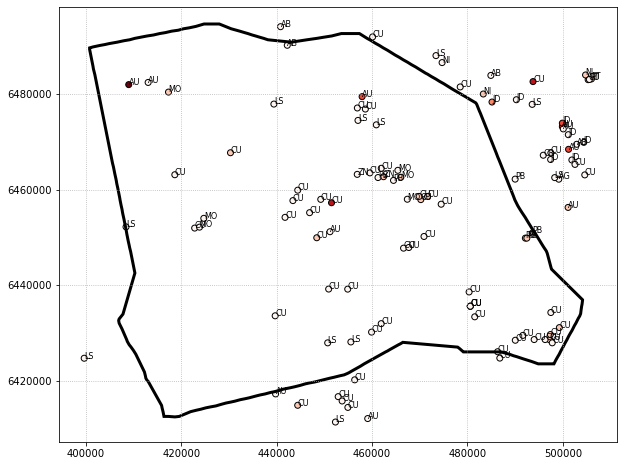

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    minfile[xcol],
    minfile[ycol],
    c=minfile["STATUS_CODE_CAT"],
    cmap="Reds_r",
    ec="k",
)
for i, lab in enumerate(minfile["COMMODITY_CODE1"].values):
    ax.annotate(
        (lab), (minfile.iloc[[i]][xcol], minfile.iloc[[i]][ycol]), fontsize=8,
    )

ax.axis("equal")
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

In [14]:
minfile["STATUS_DESCRIPTION"].value_counts()

Showing                 80
Prospect                19
Past Producer            4
Developed Prospect       2
Producer                 1
Anomaly                  1
Name: STATUS_DESCRIPTION, dtype: int64

# Keyout
- Filter occurrences that are within the geophysics boundary

In [15]:
pt_keyout = []
for point in MultiPoint(minfile[[xcol, ycol]].values):
    check = alpha_shape.contains(point)
    pt_keyout.append(check)
minfile["key"] = pt_keyout

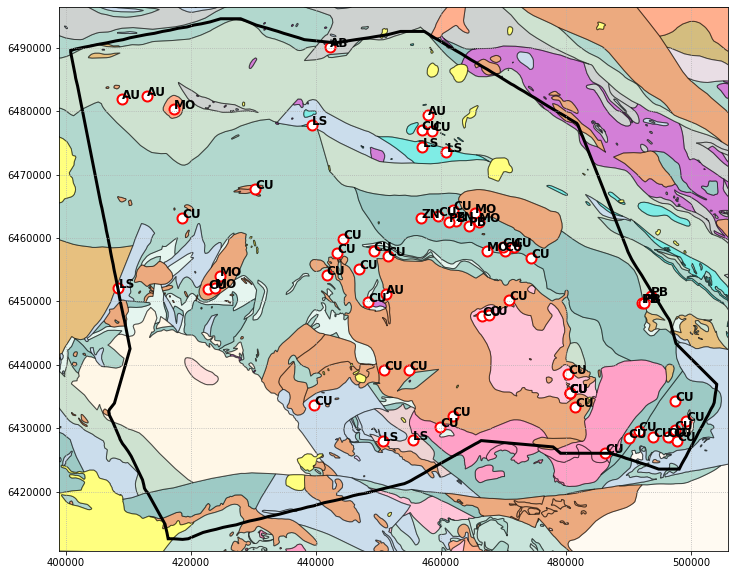

In [16]:
minfile_filter = minfile.loc[minfile["key"] == 1].copy()
fig, ax = plot_shp_poly(
    bedrock,
    4,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5, "zorder": -1},
    bbox.bbox,
    (12, 10),
)
ax.scatter(
    minfile_filter[xcol], minfile_filter[ycol], c="w", ec="r", lw=2, s=100,
)
for i, lab in enumerate(minfile_filter["COMMODITY_CODE1"].values):
    ax.annotate(
        lab,
        (minfile_filter.iloc[[i]][xcol], minfile_filter.iloc[[i]][ycol]),
        fontsize=12,
        color="k",
        weight="bold",
        #         path_effects=[pe.Stroke(linewidth=0.75, foreground="k")],
    )
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

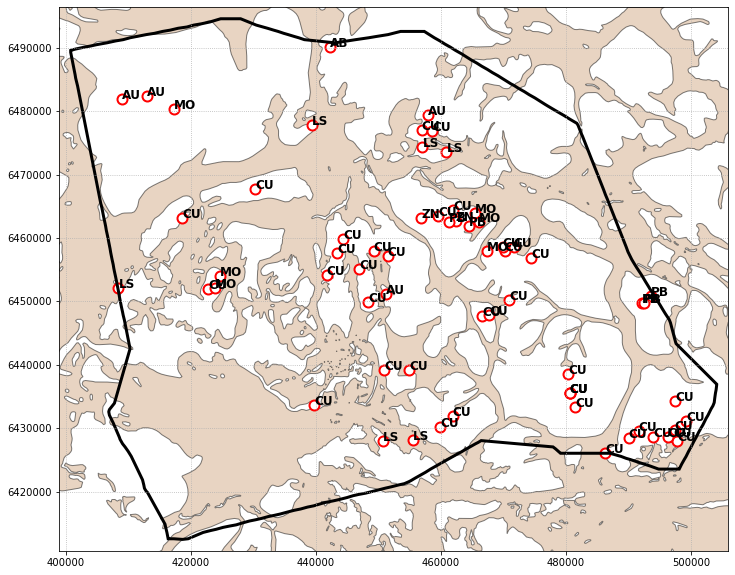

In [17]:
fig, ax = plot_shp_poly(
    cover,
    2,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5, "zorder": -1},
    bbox.bbox,
    (12, 10),
)
ax.scatter(
    minfile_filter[xcol], minfile_filter[ycol], c="w", ec="r", lw=2, s=100,
)
for i, lab in enumerate(minfile_filter["COMMODITY_CODE1"].values):
    ax.annotate(
        lab,
        (minfile_filter.iloc[[i]][xcol], minfile_filter.iloc[[i]][ycol]),
        fontsize=12,
        color="k",
        weight="bold",
        #         path_effects=[pe.Stroke(linewidth=0.75, foreground="k")],
    )
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

# Postive Examples
- Filter out Cu, Au, Mo porphry propects
- LS = limestone
- AB = asbestos

In [18]:
minfile_filter["COMMODITY_CODE1"].value_counts()

CU    41
LS     6
MO     6
PB     5
AU     4
ZN     2
AB     1
Name: COMMODITY_CODE1, dtype: int64

In [19]:
print(minfile_filter["DEPOSIT_TYPE_DESCRIPTION1"].value_counts())

Porphyry Cu +/- Mo +/- Au                                 28
Polymetallic veins Ag-Pb-Zn+/-Au                          12
Cu+/-Ag quartz veins                                       8
Limestone                                                  6
Alkalic porphyry Cu-Au                                     3
Cu skarn                                                   2
Noranda/Kuroko massive sulphide Cu-Pb-Zn                   2
Surficial placers                                          1
Volcanic redbed Cu                                         1
Cyprus massive sulphide Cu (Zn)                            1
Ultramafic-hosted asbestos                                 1
Name: DEPOSIT_TYPE_DESCRIPTION1, dtype: int64


In [20]:
labels_pos = [
    "Porphyry Cu +/- Mo +/- Au",
    "Alkalic porphyry Cu-Au",
    "Cu+/-Ag quartz veins",
    "Cu skarn",
    "Polymetallic veins Ag-Pb-Zn+/-Au",
    "Noranda/Kuroko massive sulphide Cu-Pb-Zn",
    "Volcanic redbed Cu",
    "Cyprus massive sulphide Cu (Zn)",
]

In [21]:
examples_pos = minfile_filter.loc[
    minfile_filter["DEPOSIT_TYPE_DESCRIPTION1"].str.strip().isin(labels_pos)
]
print(len(examples_pos), "postive examples")

57 postive examples


In [22]:
print(examples_pos["DEPOSIT_TYPE_DESCRIPTION1"].value_counts())

Porphyry Cu +/- Mo +/- Au                                 28
Polymetallic veins Ag-Pb-Zn+/-Au                          12
Cu+/-Ag quartz veins                                       8
Alkalic porphyry Cu-Au                                     3
Cu skarn                                                   2
Noranda/Kuroko massive sulphide Cu-Pb-Zn                   2
Volcanic redbed Cu                                         1
Cyprus massive sulphide Cu (Zn)                            1
Name: DEPOSIT_TYPE_DESCRIPTION1, dtype: int64


In [23]:
print(examples_pos["STATUS_DESCRIPTION"].value_counts())

Showing                 42
Prospect                13
Anomaly                  1
Developed Prospect       1
Name: STATUS_DESCRIPTION, dtype: int64


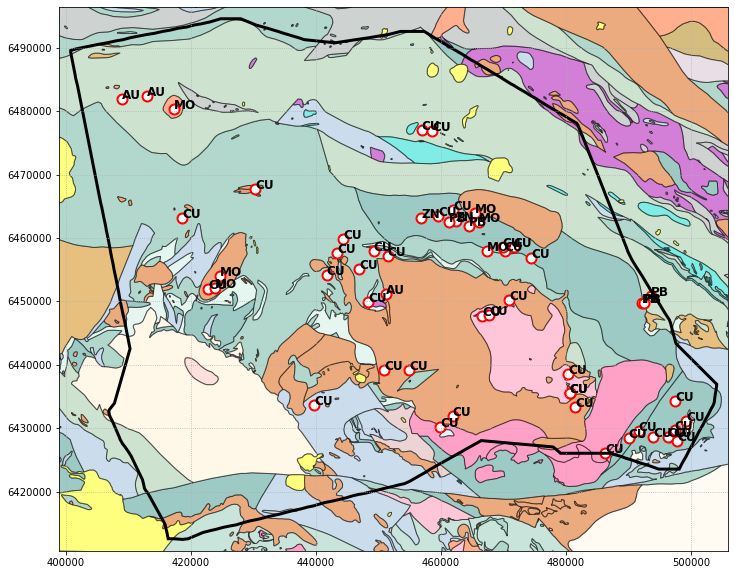

In [24]:
fig, ax = plot_shp_poly(
    bedrock,
    4,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5, "zorder": -1},
    bbox.bbox,
    (12, 10),
)
ax.scatter(
    examples_pos[xcol], examples_pos[ycol], c="w", ec="r", lw=2, s=100,
)
for i, lab in enumerate(examples_pos["COMMODITY_CODE1"].values):
    ax.annotate(
        lab,
        (examples_pos.iloc[[i]][xcol], examples_pos.iloc[[i]][ycol]),
        fontsize=12,
        color="k",
        weight="bold",
        #         path_effects=[pe.Stroke(linewidth=0.75, foreground="k")],
    )
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

- Set up grid definition for conversion between coordinates and indices
    - determine (ix, iy) from (x, y) 
- Determine grid cell indices around positive and negative examples


In [25]:
xsize = 25
ysize = 25
xmin = origin[1][0] + xsize / 2
ymin = origin[0][1] - ysize / 2  # top left

In [27]:
def coord_to_2D_idx(x, y, xmin, ymin, xsize, ysize):
    """convert (x, y) to (ix, iy) with top left origin"""
    ix = (np.ceil((x - xmin) / xsize + 0.5) - 1).astype(int)
    iy = (np.ceil((ymin - y) / ysize + 0.5) - 1).astype(int)
    return ix, iy

In [28]:
ix_pos, iy_pos = coord_to_2D_idx(
    examples_pos[xcol], examples_pos[ycol], xmin, ymin, xsize, ysize
)
to_pickle("./outputs/postive_locations.pkl", [ix_pos, iy_pos])

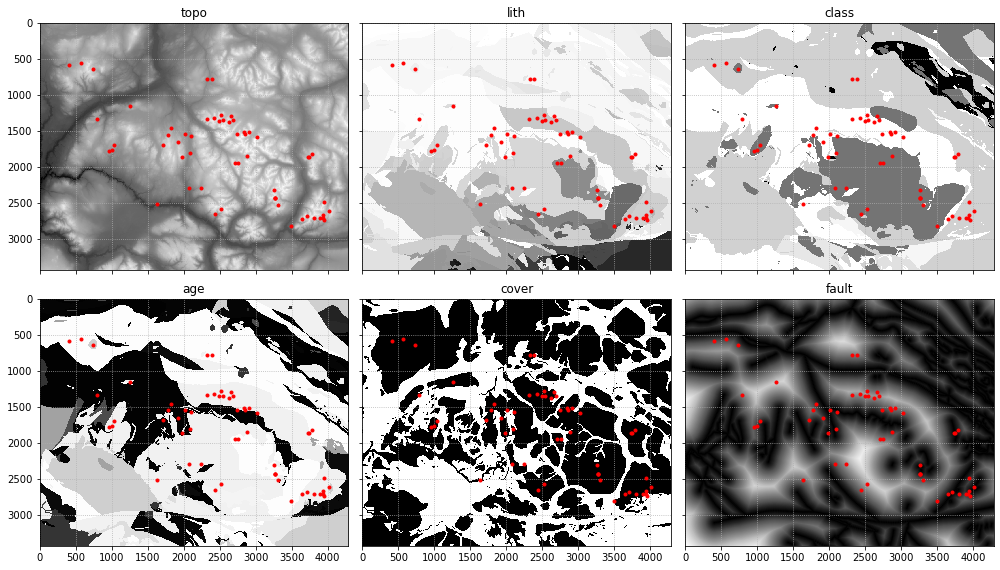

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var[..., 0], cmap="Greys_r")
    axes[i].set_title(key)
    axes[i].plot(ix_pos, iy_pos, c="r", marker=".", ls="None")
fig.tight_layout()

# Negative Examples

In [30]:
examples_neg = minfile_filter.loc[
    ~minfile_filter["DEPOSIT_TYPE_DESCRIPTION1"].str.strip().isin(labels_pos)
]
print(len(examples_neg), "negative examples")

8 negative examples


In [31]:
print(examples_neg["DEPOSIT_TYPE_DESCRIPTION1"].value_counts())

Limestone                                             6
Surficial placers                                     1
Ultramafic-hosted asbestos                            1
Name: DEPOSIT_TYPE_DESCRIPTION1, dtype: int64


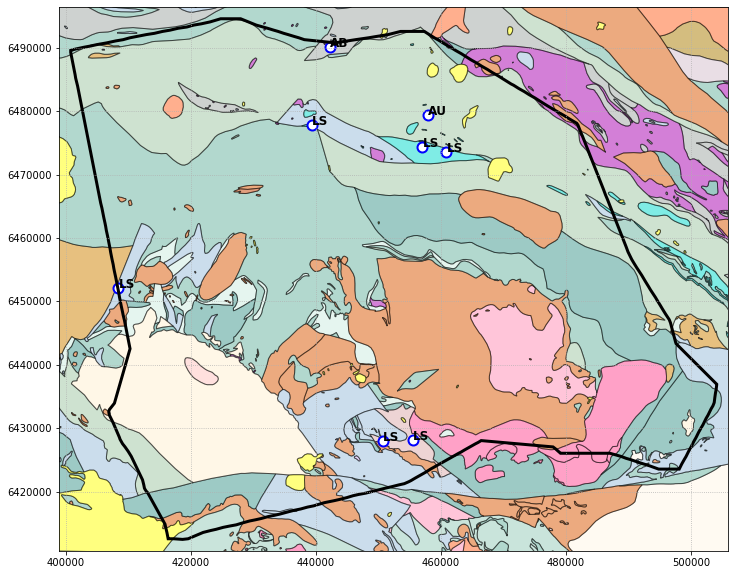

In [32]:
fig, ax = plot_shp_poly(
    bedrock,
    4,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5, "zorder": -1},
    bbox.bbox,
    (12, 10),
)
ax.scatter(
    examples_neg[xcol], examples_neg[ycol], c="w", ec="b", lw=2, s=100,
)
for i, lab in enumerate(examples_neg["COMMODITY_CODE1"].values):
    ax.annotate(
        lab,
        (examples_neg.iloc[[i]][xcol], examples_neg.iloc[[i]][ycol]),
        fontsize=12,
        color="k",
        weight="bold",
    )
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

## Generate Negative Examples
- For a balanced problem, generate negative samples:
    - with no surficial cover
    - inside the polygon 
    - greater than a distance threshold from positive samples

In [33]:
def generate_negative_examples(
    num_neg,
    examples_neg,
    examples_pos,
    xcol,
    ycol,
    cover,
    bound,
    dist_thresh,
    bbox,
    xsize,
    ysize,
    xmin,
    ymin,
    seed,
):
    rng = np.random.default_rng(seed)
    existing_pts = pd.concat([examples_pos, examples_neg], axis=0)
    new_pts = pd.DataFrame(columns=[xcol, ycol], index=np.arange(num_neg))
    tree = cKDTree(existing_pts[[xcol, ycol]].values)
    nn = 0
    it = 0

    while nn < num_neg:
        it += 1
        rand_x = rng.uniform(bbox[0], bbox[2], size=1)
        rand_y = rng.uniform(bbox[1], bbox[3], size=1)
        loc = np.array([[*rand_x, *rand_y]])

        bound_check = False
        cover_check = False
        dist_check = False

        # check boundary
        bound_check = bound.contains(MultiPoint(loc))

        if bound_check:
            # check cover
            ix, iy = coord_to_2D_idx(rand_x, rand_y, xmin, ymin, xsize, ysize)
            cover_val = cover[iy, ix]
            if cover_val < 255:
                cover_check = True

            if cover_check:
                # check distance
                dist, _ = tree.query(loc, k=1)
                if dist >= dist_thresh:
                    dist_check = True

                if dist_check:
                    new_pts.iloc[nn, :] = loc
                    nn += 1
    print(it, "iterations")
    return new_pts

In [34]:
new_neg = generate_negative_examples(
    49,
    examples_neg,
    examples_pos,
    xcol,
    ycol,
    rasters["cover"],
    alpha_shape,
    2000 * np.sqrt(2),
    bbox.bbox,
    xsize,
    ysize,
    xmin,
    ymin,
    3756,
)

203 iterations


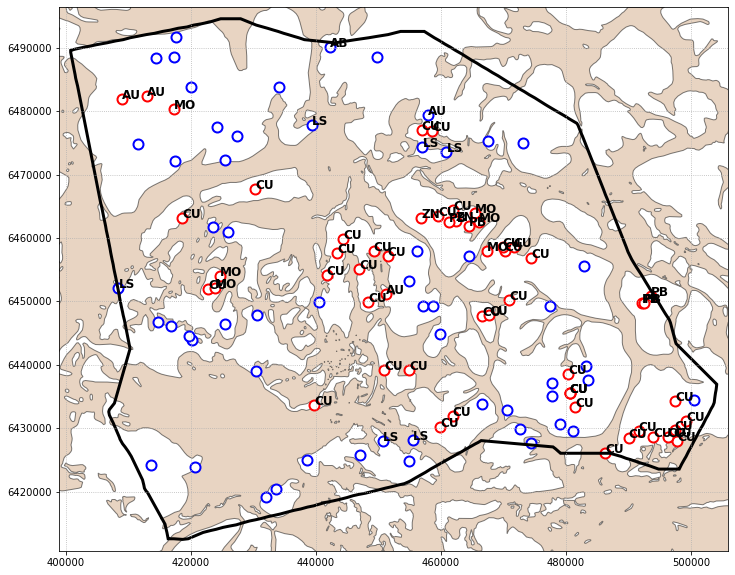

In [35]:
fig, ax = plot_shp_poly(
    cover,
    2,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5, "zorder": -1},
    bbox.bbox,
    (12, 10),
)
ax.scatter(
    new_neg[xcol], new_neg[ycol], c="w", ec="b", lw=2, s=100,
)
ax.scatter(
    examples_pos[xcol], examples_pos[ycol], c="w", ec="r", lw=2, s=100,
)
ax.scatter(
    examples_neg[xcol], examples_neg[ycol], c="w", ec="b", lw=2, s=100,
)
for i, lab in enumerate(examples_neg["COMMODITY_CODE1"].values):
    ax.annotate(
        lab,
        (examples_neg.iloc[[i]][xcol], examples_neg.iloc[[i]][ycol]),
        fontsize=12,
        color="k",
        weight="bold",
    )
for i, lab in enumerate(examples_pos["COMMODITY_CODE1"].values):
    ax.annotate(
        lab,
        (examples_pos.iloc[[i]][xcol], examples_pos.iloc[[i]][ycol]),
        fontsize=12,
        color="k",
        weight="bold",
    )
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

In [36]:
examples_neg = pd.concat([examples_neg, new_neg], axis=0)

In [38]:
ix_neg, iy_neg = coord_to_2D_idx(
    examples_neg[xcol], examples_neg[ycol], xmin, ymin, xsize, ysize
)
to_pickle("./outputs/negative_locations.pkl", [ix_neg, iy_neg])

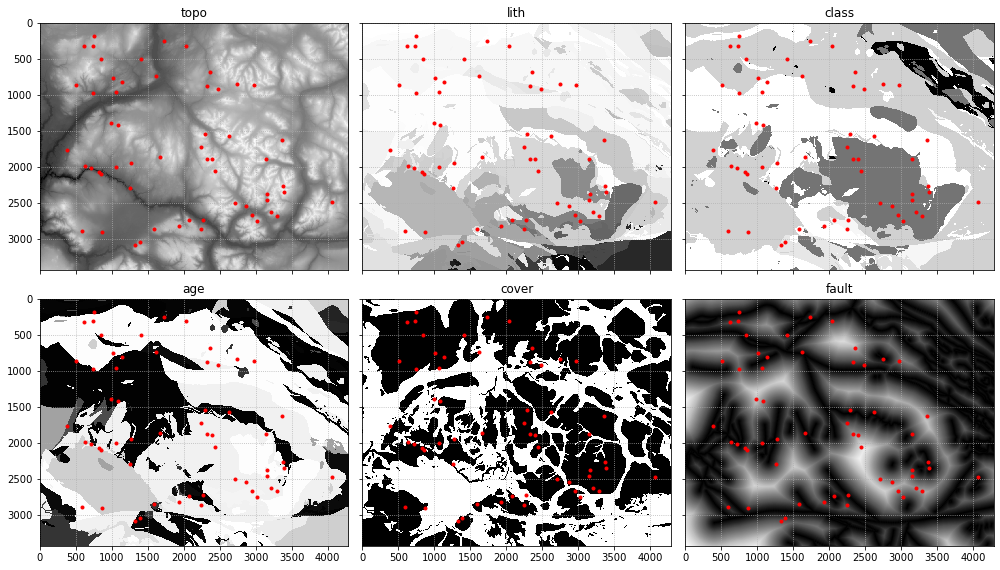

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var[..., 0], cmap="Greys_r")
    axes[i].set_title(key)
    axes[i].plot(ix_neg, iy_neg, c="r", marker=".", ls="None")
fig.tight_layout()